### Setup Project

In [1]:
import os

os.environ["CUDA_VERSION"] = ""
from src import create_and_set_project

In [2]:
project = create_and_set_project(
    name="odsc-west-2023",
    source="git://github.com/igz-us-sales/k3d-mlrun#master",
    # source="v3io:///bigdata/odsc-west-2023.zip",
    secrets_file="secrets.env",
)

> 2023-10-30 14:27:51,035 [info] Project loaded successfully: {'project_name': 'odsc-west-2023'}


### Run Training Pipeline

In [9]:
run_id = project.run(
    name="main",
    arguments={
        "dataset_name" : "databricks/databricks-dolly-15k",
        "dataset_text_field" : "text",
        "urls_file" : "./data/mlops_blogs.txt",
        "pretrained_tokenizer" : "meta-llama/Llama-2-7b-hf",
        "pretrained_model" : "meta-llama/Llama-2-7b-hf",
        "regular_model_name" : "regular-adapter",
        "pirate_model_name" : "pirate-adapter",
        "max_steps" : 1000,
        "logging_steps" : 100,
        "save_steps" : 500
    },
    dirty=True,
    watch=False,
)

> 2023-10-30 04:05:45,540 [warning] WARNING!, you seem to have uncommitted git changes, use .push()
> 2023-10-30 04:05:46,916 [info] submitted pipeline odsc-west-2023-main 2023-10-30 04-05-46 id=c6547d1b-40b4-4805-9da5-56ce383e3655
> 2023-10-30 04:05:46,917 [info] Pipeline run id=c6547d1b-40b4-4805-9da5-56ce383e3655, check UI for progress


> 2023-10-30 04:05:47,290 [info] started run workflow odsc-west-2023-main with run id = 'c6547d1b-40b4-4805-9da5-56ce383e3655' by kfp engine


### Deploy Serving Function

In [3]:
serving_fn = project.get_function("serving")
serving_fn.set_env("CUDA_VERSION", "")
serving_fn.with_node_selection(
    node_selector={"app.iguazio.com/node-group" : "added-v100"}
)
serving_fn.with_limits(gpus=1, patch=True)
serving_fn.spec.readiness_timeout = 3000
serving_fn.spec.min_replicas = 1
serving_fn.spec.max_replicas = 1

model_name = "meta-llama/Llama-2-7b-chat-hf"

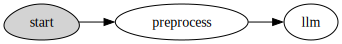

In [6]:
graph = serving_fn.set_topology("flow", engine="async", exist_ok=True)
graph.to(handler="src.functions.serving.preprocess", name="preprocess") \
     .to("src.functions.serving.LLMModelServer",
         name="llm",
         model_args={
             "load_in_4bit": True,
             "device_map": "auto",
             "trust_remote_code": True,
             "return_dict" : True
         },
         tokenizer_name=model_name,
         model_name=model_name,
         adapters={
             "pirate" : project.get_artifact_uri("pirate-adapter"),
             "regular" : project.get_artifact_uri("regular-adapter")
         },
         stop_token = "##"
        ).respond()

serving_fn.plot(rankdir='LR')

In [7]:
project.deploy_function(serving_fn)

> 2023-10-30 14:28:43,469 [info] Starting remote function deploy
2023-10-30 14:28:43  (info) Deploying function
2023-10-30 14:28:43  (info) Building
2023-10-30 14:28:44  (info) Staging files and preparing base images
2023-10-30 14:28:44  (info) Building processor image
2023-10-30 14:40:45  (info) Build complete
2023-10-30 14:52:35  (info) Function deploy complete
> 2023-10-30 14:52:41,372 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-odsc-west-2023-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['odsc-west-2023-serving-odsc-west-2023.default-tenant.app.cst-354.iguazio-cd2.com/']}


DeployStatus(state=ready, outputs={'endpoint': 'http://odsc-west-2023-serving-odsc-west-2023.default-tenant.app.cst-354.iguazio-cd2.com/', 'name': 'odsc-west-2023-serving'})

### Test Serving

In [8]:
serving_fn = project.get_function("serving")

In [19]:
%%time
prompt = "can mlrun work with spark?"

body = {
    "prompt" : prompt,
    "adapter" : "pirate",
    "rag" : True,
    "k" : 2,
    "max_new_tokens": 50,
    "temperature": 0.5,
    "top_p": 0.7,
}

response = serving_fn.invoke(path='/predict', body=body)

> 2023-10-30 15:08:12,090 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-odsc-west-2023-serving.default-tenant.svc.cluster.local:8080/predict'}
CPU times: user 16.3 ms, sys: 0 ns, total: 16.3 ms
Wall time: 6.48 s


In [20]:
print(response["outputs"]["prediction"])

Aye, mlrun can work with spark. Th' mlrun spark operator runtime provides a way to run spark operators within mlrun, allowing for easier management and scaling of spark applications.


### Chatbot UI

In [15]:
import json

import gradio as gr
import requests

In [16]:
serving_fn = project.get_function("serving")

In [17]:
def generate(prompt, adapter, rag, k, temperature, max_length, top_p, top_k, repetition_penalty):
    # Build the request for our serving graph:
    inputs = {
        "prompt": prompt,
        "adapter" : adapter.lower(),
        "rag" : rag,
        "k" : k,
        "temperature": temperature,
        "max_length": max_length,
        "top_p": top_p,
        "top_k": top_k,
        "repetition_penalty": repetition_penalty,
    }
    
    output = serving_fn.invoke(path='/predict', body=inputs)["outputs"]["prediction"]
    
    if not output:
        output = "Context window exceeded - increase max length"
    
    # Return the response:
    return output


# Set up a Gradio frontend application:
with gr.Blocks(analytics_enabled=False, theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """# LLM Playground
Play with the `generate` configurations and see how they make the LLM's responses better or worse.
"""
    )
    with gr.Row():
        with gr.Column(scale=5):
            with gr.Row():
                chatbot = gr.Chatbot()
            with gr.Row():
                prompt = gr.Textbox(label="Subject to ask about:", placeholder="Type a question and Enter")

        with gr.Column(scale=1):
            adapter = gr.Dropdown(label="Adapter", value="Pirate", choices=["Regular", "Pirate"], info="Choose fine tuned adapter")
            rag = gr.Checkbox(label="RAG Enrichment", value=True)
            k = gr.Slider(minimum=0, maximum=5, value=2, label="Num Sources", step=1)
            temperature = gr.Slider(minimum=0, maximum=1, value=0.9, label="Temperature", info="Choose between 0 and 1")
            max_length = gr.Slider(minimum=0, maximum=1500, value=150, label="Maximum length", info="Choose between 0 and 1500")
            top_p = gr.Slider(minimum=0, maximum=1, value=0.5, label="Top P", info="Choose between 0 and 1")
            top_k = gr.Slider(minimum=0, maximum=500, value=25, label="Top k", info="Choose between 0 and 500")
            repetition_penalty = gr.Slider(minimum=0, maximum=1, value=1, label="repetition penalty", info="Choose between 0 and 1")
            clear = gr.Button("Clear")

    def respond(prompt, chat_history, adapter, rag, k, temperature, max_length, top_p, top_k, repetition_penalty):
        bot_message = generate(prompt, adapter, rag, k, temperature, max_length, top_p, top_k, repetition_penalty)
        chat_history.append((prompt, bot_message))

        return "", chat_history

    prompt.submit(respond, [prompt, chatbot, adapter, rag, k, temperature, max_length, top_p, top_k, repetition_penalty], [prompt, chatbot])
    clear.click(lambda: None, None, chatbot, queue=False)

In [ ]:
demo.launch(share=True, height=1500)

In [21]:
demo.close()

Closing server running on port: 7860
